In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import math
sns.set_theme()
og_df = pd.read_csv('archive/acs2017_county_data.csv')
# df.describe()

# plt.hist(og_df['Income'], bins=100)

ystr = "Count"
xstr = "Income"

wfh_v_private = px.histogram(og_df, x=xstr, title="Income").update_layout(yaxis_title=ystr, xaxis_title=xstr)
# wfh_v_private
og_df.columns


Index(['CountyId', 'State', 'County', 'TotalPop', 'Men', 'Women', 'Hispanic',
       'White', 'Black', 'Native', 'Asian', 'Pacific', 'VotingAgeCitizen',
       'Income', 'IncomeErr', 'IncomePerCap', 'IncomePerCapErr', 'Poverty',
       'ChildPoverty', 'Professional', 'Service', 'Office', 'Construction',
       'Production', 'Drive', 'Carpool', 'Transit', 'Walk', 'OtherTransp',
       'WorkAtHome', 'MeanCommute', 'Employed', 'PrivateWork', 'PublicWork',
       'SelfEmployed', 'FamilyWork', 'Unemployment'],
      dtype='object')

In [2]:

#Casey
def pruning_and_binning (og_df, labelBins, labels, labelCol):
    
    
    df_pruned = og_df
    df_pruned = df_pruned.drop('CountyId', axis=1)
    df_pruned = df_pruned.drop('County', axis=1) 
    
    df_pruned['MenPercent'] = round(df_pruned['Men'] / df_pruned['TotalPop'], 2)
    # df_pruned['WomenPercent'] = round(df_pruned['Women'] / df_pruned['TotalPop'], 2)
    df_pruned = df_pruned.drop('Men', axis=1)
    df_pruned = df_pruned.drop('Women', axis=1)
    
    df_pruned = df_pruned.drop('Pacific', axis=1)

    if(labelCol == 'Income'):
        df_pruned = df_pruned.drop('IncomePerCap', axis=1)
        df_pruned = df_pruned.drop('IncomePerCapErr', axis=1)
        df_pruned = df_pruned.drop('IncomeErr', axis=1)
    elif(labelCol == 'IncomePerCap'):
        df_pruned = df_pruned.drop('Income', axis=1)
        df_pruned = df_pruned.drop('IncomePerCapErr', axis=1)
        df_pruned = df_pruned.drop('IncomeErr', axis=1)
    
    
    # df_additions.head()
    # df_additions.columns

    # Bin Everything
    df_binned = df_pruned

    # For Specific sized bins
    df_binned[labelCol] = pd.cut(x = df_pruned[labelCol], bins = labelBins, labels = labels, include_lowest = True)

    for i in range(len(df_binned.columns)-1):
        colName = df_binned.columns[i+1]
        if(colName != labelCol):
            feature_labels = ['Low', 'Mid', 'High']
            df_binned[colName], cut_bin = pd.qcut(x = df_pruned[colName], q = 3, labels = feature_labels, retbins = True)
        # print(colName)
        # print(labels)
        # print(cut_bin)
    
    print("Pruned & Binned\n")
    return df_binned
    
# df_binned.head()

In [3]:
# Splitting into a sample & test set
#Casey
def get_trainingSet_and_testSet(df_binned, fraction):
    # Gets a fraction as a training set
    df_training = df_binned.sample(frac=fraction, replace=False, axis=0)
    # Takes the rest and returns it as a test set
    df_testSet = df_binned[~df_binned.isin(df_training)].dropna(how = 'all')
    # Shuffle Test Set
    df_testSet = df_testSet.sample(frac=1, replace=False, axis=0)
    print("Split & Shuffled\n")
    return df_training, df_testSet
    

In [4]:
# Building a Baysian model
#Casey
def build_naive_bayes_model(df_train, labelCol):
    labelCounts = pd.Series(df_train[labelCol].value_counts())
    labelMarginals = labelCounts / len(df_train)
    labelConditionals = []

    for i in range(len(labelCounts)):
        labelConditionals.append([])
        curLabel = df_train[labelCol].value_counts().index[i]
        df_conditional = df_train[df_train[labelCol] == curLabel]

        for j in range(len(df_conditional.columns)):
            colOfInterest = [df_conditional.columns[j]]

            df1 = df_conditional[colOfInterest].value_counts()
            df1 = df1.astype(float)
            df1 = (df1 + 1) / (labelCounts[i]+1)

    #       Check for values not in the sample and set them to 1/labelCounts
            for k in range(len(df_train[colOfInterest].value_counts())):
                indexVal = df_train[colOfInterest].value_counts().index[k]
                if(indexVal not in df1.index):
                    newDF = pd.Series([1/(labelCounts[i]+1)], [indexVal])
                    df1 = pd.concat([df1, newDF])
            labelConditionals[i].append(df1)

    # print(labelConditionals)
    print("Model Built\n")
    
    return labelMarginals, labelConditionals

In [5]:
#Casey
def eval_with_bayes_model(df_testSet, labelMarginals, labelConditionals, label, labels):
    print("Running Inference Task\n")

    totalOutput = pd.Series([0]*len(labels), labels)
    correctOutput = pd.Series([0]*len(labels), labels)
    numCorrect = 0

    for k in range(len(df_testSet)):
        df_row = df_testSet.iloc[k]

        labelProbabilities = labelMarginals.copy()

        for i in range(len(labelProbabilities)):
            for j in range(len(df_row)):
                if(df_row.index[j] != label):
                    x = labelConditionals[i][j]
                    # print(x.loc[df_row[j]][0])
                    # print(df_row[j])
                    if df_row[j] in x:
                        labelProbabilities[i] *= x.loc[df_row[j]][0]



        totalOutput.loc[labelProbabilities.idxmax()] += 1
        if(labelProbabilities.idxmax() == df_row.loc[label]):
            numCorrect += 1
            correctOutput.loc[labelProbabilities.idxmax()] += 1

        if(False):
            print("Inference")
            print("Prediction: ")
            print("Actual: ")
            print(df_row[label])
            print(labelProbabilities.idxmax())

    return totalOutput, correctOutput

In [6]:
#Casey
def printResults(df_testSet, totalOutput, correctOutput, labelCol):
    print("Distribution of TestSet Data:")
    print(df_testSet[labelCol].value_counts())
    print()
    print("Total Output Distribution: ")
    print(totalOutput)
    print()
    print("CorrectOutput Distribution: ")
    print(correctOutput)
    print()
    print("NumCorrect: " + str(correctOutput.sum()))
    print("Accuracy: "  + str(correctOutput.sum() / len(df_testSet)))
    # pres = numCorrect / len(df_testSet)
    # print("Precision: "  + str(pres)
    # rec = 
    # print("Recall: "  + str(rec)

In [20]:
#Casey
def runNaiveBayes(labelCol, bins, labels):

    og_df = pd.read_csv('archive/acs2017_county_data.csv')

    df_binned = pruning_and_binning(og_df, bins, labels, labelCol)

    df_train, df_test = get_trainingSet_and_testSet(df_binned, 0.8)

    label_marg, label_cond = build_naive_bayes_model(df_train, labelCol)

    totalOutput, correctOutput = eval_with_bayes_model(df_test, label_marg, label_cond, labelCol, labels)

    print("Results:")
    print("\nLabel: " + str(labelCol))
    print("Bins: " + str(bins))
    print("Labels: " + str(labels) + "\n")
    # print("\nLabel distribution: ")
    # print(label_marg)

    printResults(df_test, totalOutput, correctOutput, labelCol)
    return df_test, totalOutput, correctOutput, labelCol

In [51]:
# Found from kaggle and adjusted to display my information
def plotBayes(df_test, correctOutput, labelCol):
    plt.rcParams["figure.figsize"] = [7.00, 3.50]
    plt.rcParams["figure.autolayout"] = True

    labels = df_test[labelCol].value_counts().index.tolist()
    test_set_numbers = df_test[labelCol].value_counts().tolist()
    output_numbers = correctOutput.sort_index()

    x = np.arange(len(labels))
    width = 0.35

    fig, ax = plt.subplots()
    rects1 = ax.bar(x - width / 2, test_set_numbers, width, label='Actual')
    rects2 = ax.bar(x + width / 2, output_numbers, width, label='Predicted')

    ax.set_ylabel('Count')
    ax.set_title('Number of ' + labelCol + ' bins correctly predicted')
    ax.set_xticks(x)
    ax.set_xticklabels(labels)
    ax.legend()

    def autolabel(rects):
       for rect in rects:
          height = rect.get_height()
          ax.annotate('{}'.format(height),
             xy=(rect.get_x() + rect.get_width() / 2, height),
             xytext=(0, 3), # 3 points vertical offset
             textcoords="offset points",
             ha='center', va='bottom')

    autolabel(rects1)
    autolabel(rects2)

    print(plt.show())

In [61]:
def predictWithBayes(df_row, labelMarginals, labelConditionals, label):
    labelProbabilities = labelMarginals.copy()

    for i in range(len(labelProbabilities)):
        for j in range(len(df_row)):
            if(df_row.index[j] != label):
                x = labelConditionals[i][j]
                # print(x.loc[df_row[j]][0])
                # print(df_row[j])
                if df_row[j] in x:
                    labelProbabilities[i] *= x.loc[df_row[j]][0]
    return labelProbabilities.idxmax()

Pruned & Binned

Split & Shuffled

Model Built

Running Inference Task

Results:

Label: IncomePerCap
Bins: [0, 25000, inf]
Labels: ['Low', 'High']

Distribution of TestSet Data:
High    330
Low     314
Name: IncomePerCap, dtype: int64

Total Output Distribution: 
Low     305
High    339
dtype: int64

CorrectOutput Distribution: 
Low     267
High    292
dtype: int64

NumCorrect: 559
Accuracy: 0.8680124223602484


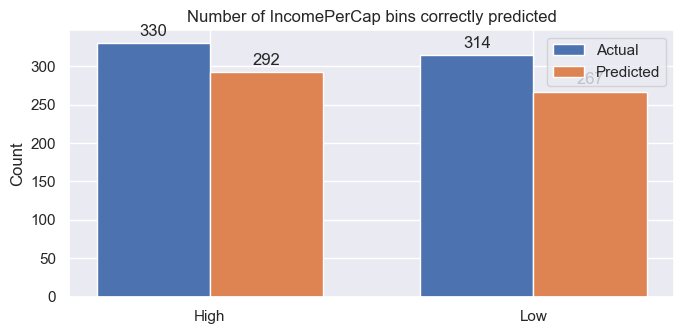

None


In [52]:
# labelCol = 'IncomePerCap'
# labels = ['Low', 'Low-Med','High-Med', 'High']
# labels = ['Low', 'Med', 'High']
# labels = ['Low', 'High']
# df_discard, cut_bin = pd.qcut(x = og_df[labelCol], q = len(labels), labels = labels, retbins = True)
# df_test, totalOutput, correctOutput, labelCol = runNaiveBayes(labelCol, cut_bin, labels) 

# df_test, totalOutput, correctOutput, labelCol = runNaiveBayes('Income', [0, 45000, math.inf], ['Low', 'High']) #85%
df_test, totalOutput, correctOutput, labelCol = runNaiveBayes('IncomePerCap', [0, 25000, math.inf], ['Low', 'High']) 
# runNaiveBayes('Income', [0, 50000, math.inf], ['Low', 'High']) #81%
# runNaiveBayes('Income', [0, 36000, 56000, math.inf], ['Low', 'Med', 'High']) #75%

plotBayes(df_test, correctOutput, labelCol)

In [64]:
labelCol = 'IncomePerCap'
bins = [0, 25000, math.inf]
labels = ['Low', 'High']

og_df = pd.read_csv('archive/acs2017_county_data.csv')

df_binned = pruning_and_binning(og_df, bins, labels, labelCol)

df_train, df_test = get_trainingSet_and_testSet(df_binned, 0.8)

label_marg, label_cond = build_naive_bayes_model(df_train, labelCol)

predictWithBayes(df_test.iloc[0], label_marg, label_cond, labelCol)

Pruned & Binned

Split & Shuffled

Model Built



'High'

In [76]:
labelCol = 'IncomePerCap'
bins = [0, 25000, math.inf]
labels = ['Low', 'High']

og_df = pd.read_csv('archive/acs2017_county_data.csv')

df_trainPreBin, df_testPreBin = get_trainingSet_and_testSet(og_df, 0.8)

label_marg, label_cond, df_test = generateNaiveBayesModel(df_testPreBin, df_trainPreBin, labels, labelCol)

predictWithBayes(df_test.iloc[0], label_marg, label_cond, labelCol)

Split & Shuffled

Pruned & Binned

Pruned & Binned

Model Built



'Low'

In [74]:
def generateNaiveBayesModel(test_set, train_set, labels, labelCol):
    df_test = pruning_and_binning(test_set, bins, labels, labelCol)
    df_train = pruning_and_binning(train_set, bins, labels, labelCol)

    label_marg, label_cond = build_naive_bayes_model(df_train, labelCol)
    return label_marg, label_cond, df_test
    

In [10]:
# for i in range(len(df_additions.columns)):
#     print(df_additions.columns[i])
#     plot = px.histogram(df_additions, x=df_additions.columns[i], title=df_additions.columns[i]).update_layout(yaxis_title='Count', xaxis_title=df_additions.columns[i])
#     plot.show()